In [1]:
# imports 

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np 
from collections import Counter
from Bio import SeqIO

In [2]:
# read in the metadata 
metadata = pd.read_csv('../metadata/residual_community_metadata.csv')

In [3]:
# read in the checkm2 quality report
checkm2 = pd.read_csv('../data/MAGs/quality_report.tsv', sep = '\t')

In [4]:
checkm2_completeness70 = checkm2[checkm2['Completeness'] > 70]
checkm2_completeness70_contamination15 = checkm2_completeness70[checkm2_completeness70['Contamination'] < 15]

In [5]:
checkm2_completeness70_contamination15

,Name,Completeness,Contamination,Completeness_Model_Used,Translation_Table_Used,Coding_Density,Contig_N50,Average_Gene_Length,Genome_Size,GC_Content,Total_Coding_Sequences,Additional_Notes
0,S1C1,96.03,5.08,Neural Network (Specific Model),11,0.895,60454,311.881829,5502427,0.54,5272,NaN
15,S1C2,99.05,4.83,Gradient Boost (General Model),11,0.858,40227,310.244388,3809550,0.37,3519,NaN
29,S1C3,94.66,9.27,Neural Network (Specific Model),11,0.887,37251,300.340281,2092511,0.40,2063,NaN
35,S1C4,89.37,6.87,Neural Network (Specific Model),11,0.893,30491,294.716853,5113346,0.52,5174,NaN
39,S1C5,92.09,1.79,Gradient Boost (General Model),11,0.869,17918,300.205139,2377930,0.27,2296,NaN
41,S1C52,87.59,9.99,Neural Network (Specific Model),11,0.881,13544,301.545319,4807406,0.56,4689,NaN
43,S1C53,77.75,5.29,Neural Network (Specific Model),11,0.884,9985,290.647319,4002029,0.57,4066,NaN
47,S1C56,91.99,14.36,Neural Network (Specific Model),11,0.880,6395,269.159992,4617109,0.53,5044,NaN
49,S1C58,75.59,0.49,Neural Network (Specific Model),11,0.860,7887,280.096084,3783746,0.48,3882,NaN
53,S1C6,89.95,3.96,Neural Network (Specific Model),11,0.870,13776,281.385235,2163445,0.39,2235,NaN


In [6]:
# read in the taxonomy 
gtdb = pd.read_csv('../data/MAGs/gtdbtk.bac120.summary.tsv', sep = '\t')

In [7]:
gtdb[gtdb['user_genome'].isin(checkm2_completeness70_contamination15['Name'])][['user_genome', 'classification']]

,user_genome,classification
0,S1C1,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...
15,S1C2,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__T...
29,S1C3,d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactob...
35,S1C4,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...
39,S1C5,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__P...
41,S1C52,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...
43,S1C53,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...
47,S1C56,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...
49,S1C58,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...
53,S1C6,d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactob...


In [9]:
# read in the coverage information
koverage = pd.read_csv('../data/MAGs/sample_coverage.tsv', sep = '\t')
koverage['Contig_s'] = [re.split(':', c)[1] for c in koverage['Contig']]
koverage['bin'] = [re.split(':', c)[0] for c in koverage['Contig']]

In [10]:
# compute the coverage of contigs by reading in the contigs file with biopython and then using the names in the headers to create a dictionaSry 
contigs = dict(SeqIO.index('../data/MAGs/final.contigs.fa', "fasta"))
contig_keys = list(contigs.keys())
contig_length = [re.split('=', contigs.get(k).description)[-1]for k in contig_keys]
contig_length_dict = dict(zip(contig_keys, contig_length))

# update the coverage table with the information
koverage['length'] = pd.to_numeric([contig_length_dict.get(c[3:]) for c in koverage['Contig_s']])
koverage['mean.length'] = pd.to_numeric(koverage['length']).multiply(pd.to_numeric(koverage['Mean']))

In [11]:
bin_meancoverage = koverage.groupby(['Sample','bin'])['mean.length'].sum().reset_index()
bin_length = koverage[['Contig_s', 'bin', 'length']].drop_duplicates().groupby(['bin'])['length'].sum().reset_index()
bin_length_dict = dict(zip(bin_length['bin'], bin_length['length']))
# add the new measure to the table 
bin_meancoverage['mean.length/bin_length'] = [bin_meancoverage.loc[index]['mean.length']/bin_length_dict.get(s) for index, s in enumerate(bin_meancoverage['bin'])]


bin_meancoverage['bin'] = [b[:-4] for b in bin_meancoverage['bin']]
bin_meancoverage_complete = bin_meancoverage[bin_meancoverage['bin'].isin(checkm2_completeness70_contamination15['Name'].to_list())]
gtdb_dict = dict(zip(gtdb['user_genome'], gtdb['classification']))
bin_meancoverage_complete['classification'] = [gtdb_dict.get(b) for b in bin_meancoverage_complete['bin']]
bin_meancoverage_complete['Sample'] = [s[:-4] for s in bin_meancoverage_complete['Sample']] 
order_dict = dict(zip(metadata['FAME ID (leave blank)'], metadata['Order']))
bin_meancoverage_complete['order'] = [order_dict[s] for s in bin_meancoverage_complete['Sample']]
bin_meancoverage_complete = bin_meancoverage_complete.sort_values('order')
#bin_meancoverage_complete['label'] = [bin_meanrp_complete['bin'].iloc[index] + ';' + re.split(';', s)[-3][3:] + ';'+ re.split(';', s)[-1][3:] for index, s  in enumerate(bin_meanrpkm_complete['classification'])] 

<ipython-input-11-d65cddff0278>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bin_meancoverage_complete['classification'] = [gtdb_dict.get(b) for b in bin_meancoverage_complete['bin']]
<ipython-input-11-d65cddff0278>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bin_meancoverage_complete['Sample'] = [s[:-4] for s in bin_meancoverage_complete['Sample']]
<ipython-input-11-d65cddff0278>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [12]:
# loop to generate labels: 
labels = [] 

for index, s in enumerate(bin_meancoverage_complete['classification']): 
    
    species = re.split(';', s)[-1][3:]
    label = '' 
    
    if species == '': 
        genus = re.split(';', s)[-2][3:]
        
        if genus == '': 
            family = re.split(';', s)[-3][3:]
            
            if family == '': 
                label = 'unknown' 
            
            elif family == 'GPF-1':
                order = re.split(';', s)[-4][3:] 
                label = order + ' ' + family + ' sp.'
            
            else: 
                label = family + ' sp.'
        
        else: 
            label = genus + ' sp.'
    
    elif 'RHBSTW-00994' in species: 
        family = re.split(';', s)[-3][3:] 
        label = family + ' RHBSTW-00994 sp.' 
    else: 
        label = species 
    
    labels.append(bin_meancoverage_complete['bin'].iloc[index] + '; ' + label) 
    
bin_meancoverage_complete['label'] = labels


 Look at different color schemes for the heatmap. Try tearing the band away from the other samples 

In [15]:
# just make this heatmap in R using the pheatmap package 
df = bin_meancoverage_complete.pivot(index = 'label', columns = 'Sample', values = 'mean.length/bin_length')
df = df[metadata['FAME ID (leave blank)']]
df['species'] = [s for s in df.index]
df = df.sort_values('species', ascending=False).drop('species', axis=1)
df.fillna(0).to_csv('../output_files/MAG_abundance_residual.csv')

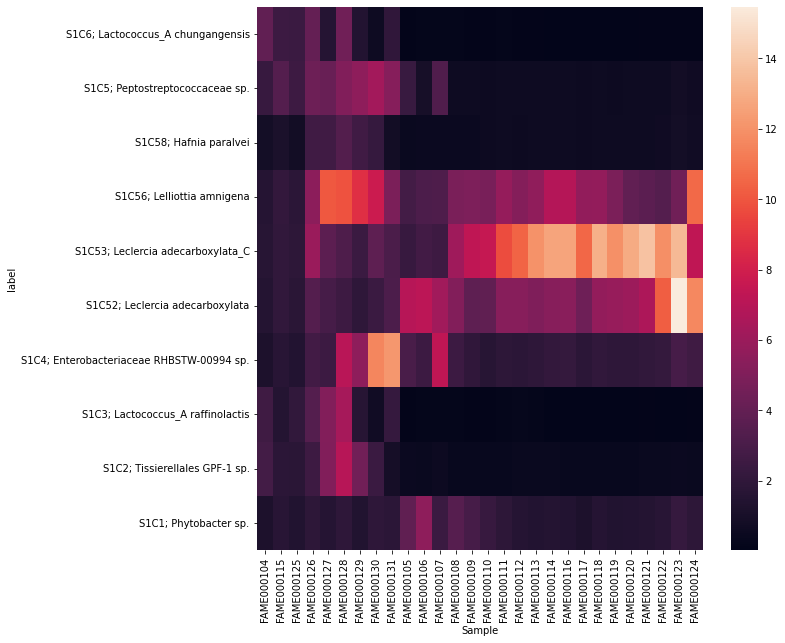

In [16]:
plt.figure(figsize=(10, 10))
sns.heatmap(np.sqrt(df[df.columns[:-1]]))
plt.show()


In [14]:
# should normalise these by the number of genes present 

In [17]:
# read in information on the subsystems 
subsystems = pd.read_csv('../data/MAGs/BV_BRC_subsystems.tsv', sep = '\t')
genomes = list(set(subsystems['genome_name']))

class_counts = pd.DataFrame() 

level = 'class'

for g in genomes: 
    s = subsystems[subsystems['genome_name'] == g]
    counts = pd.DataFrame.from_dict(Counter(s[level]), orient = 'index') 
    counts.columns = [g[9:]] 
     
    class_counts = pd.concat([class_counts,counts], axis=1 )
    
class_counts = class_counts.T
#class_counts = class_counts.div(class_counts.sum(axis=1), axis=0)*100
class_counts = class_counts.loc[[re.split(';', i)[0] for i in df.index]]
class_counts.to_csv('MAG ' + level + 'abundance_residual.csv')

In [18]:
subsystems['genome_name'] = [re.split('Bacteria ',s)[1] for s in subsystems['genome_name']]

<AxesSubplot:>

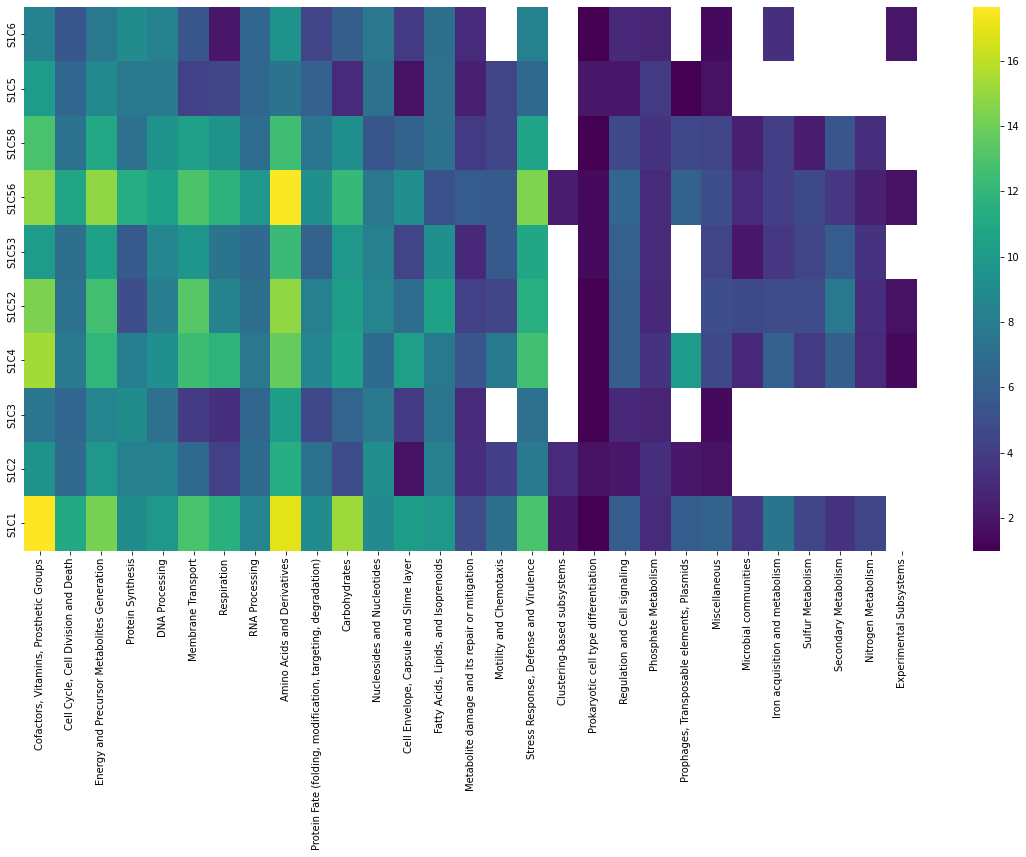

In [19]:
a = ['S1C6',
 'S1C5',
 'S1C58',
 'S1C56',
 'S1C53',
 'S1C52',
 'S1C4',
 'S1C3',
 'S1C2',
 'S1C1']
plt.figure(figsize=(20, 10))
sns.heatmap(np.sqrt(class_counts.loc[a]), cmap = "viridis")

In [21]:
S1C52_functions = subsystems[subsystems['genome_name'] == 'S1C52']
S1C53_functions = subsystems[subsystems['genome_name'] == 'S1C53']

S1C52_chemotaxis = S1C52_functions[S1C52_functions['class'] == 'Motility and Chemotaxis']
S1C53_chemotaxis = S1C53_functions[S1C53_functions['class'] == 'Motility and Chemotaxis']

In [22]:
total_chemotaxis = list(set(S1C52_chemotaxis['product']).union(set(S1C53_chemotaxis['product'])))
MAG_chemotaxis_functions = pd.DataFrame({
'S1C53': [1 if i in list(S1C53_chemotaxis['product']) else 0 for i in total_chemotaxis], 'S1C52': [1 if i in list(S1C52_chemotaxis['product']) else 0 for i in total_chemotaxis]})
MAG_chemotaxis_functions.index = total_chemotaxis


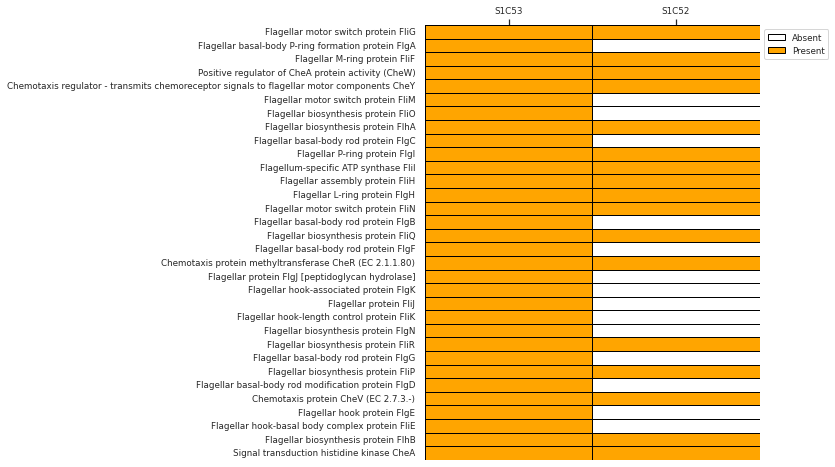

In [23]:
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

sns.set(style = 'white', font_scale=0.8)
plt.figure(figsize=(6, 8))
cmap = ListedColormap(['white', 'orange'])

# Create the heatmap with the custom color map and move x-ticks to the top
sns.heatmap(MAG_chemotaxis_functions, cmap=cmap, cbar=False, xticklabels=True, linewidths=0.5, linecolor='black')
plt.xticks(rotation=90)  # Rotate x-ticks for better readability
plt.gca().xaxis.tick_top()  # Move x-ticks to the top

# Create a custom legend
legend_elements = [Patch(facecolor='white', edgecolor='black', label='Absent'),
                   Patch(facecolor='orange', edgecolor='black', label='Present')]

# Add the legend to the plot, outside the plot area
plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))

# Show the plot
plt.show()

### Come up with a custom set of chemotaxis and flagellar proteins

In [24]:
protein_categories = {
    'Chemotaxis Signal Transduction Proteins': [
        'Chemotaxis protein CheC -- inhibitor of MCP methylation',
        'Chemotaxis protein CheD',
        'Chemotaxis protein CheV (EC 2.7.3.-)',
        'Chemotaxis protein CheX',
        'Signal transduction histidine kinase CheA',
        'Positive regulator of CheA protein activity (CheW)'
    ],
    'Chemotaxis Regulatory Proteins': [
        'Chemotaxis protein methyltransferase CheR (EC 2.1.1.80)',
        'Chemotaxis regulator - transmits chemoreceptor signals to flagellar motor components CheY',
        'Chemotaxis response - phosphatase CheZ',
        'Chemotaxis response regulator protein-glutamate methylesterase CheB (EC 3.1.1.61)'
    ],
    'Flagellar Motor Proteins': [
        'Flagellar motor rotation protein MotA',
        'Flagellar motor rotation protein MotB',
        'Flagellar motor switch protein FliG',
        'Flagellar motor switch protein FliM',
        'Flagellar motor switch protein FliN'
    ],
    'Flagellar Assembly Proteins': [
        'Flagellar assembly protein FliH',
        'Flagellar basal body-associated protein FliL',
        'Flagellar basal-body P-ring formation protein FlgA',
        'Flagellar hook-basal body complex protein FliE',
        'Flagellar hook-length control protein FliK'
    ],
    'Flagellar Structural Proteins': [
        'Flagellar L-ring protein FlgH',
        'Flagellar M-ring protein FliF',
        'Flagellar P-ring protein FlgI',
        'Flagellar basal-body rod protein FlgB',
        'Flagellar basal-body rod protein FlgC',
        'Flagellar basal-body rod protein FlgF',
        'Flagellar basal-body rod protein FlgG',
        'Flagellar cap protein FliD',
        'Flagellar hook protein FlgE',
        'Flagellar hook-associated protein FlgK',
        'Flagellar hook-associated protein FlgL',
        'Flagellin FliC'
    ],
    'Flagellar Biosynthesis Proteins': [
        'Flagellar biosynthesis protein FlgN',
        'Flagellar biosynthesis protein FlhA',
        'Flagellar biosynthesis protein FlhB',
        'Flagellar biosynthesis protein FliO',
        'Flagellar biosynthesis protein FliP',
        'Flagellar biosynthesis protein FliQ',
        'Flagellar biosynthesis protein FliR',
        'Flagellar biosynthesis protein FliS',
        'Flagellar biosynthesis protein FliT'
    ],
    'Flagellar Regulators': [
        'Flagellar regulator flk',
        'Flagellar transcriptional activator FlhC',
        'Flagellar transcriptional activator FlhD',
        'LysR family transcriptional regulator HdfR',
        'Negative regulator of flagellin synthesis FlgM (anti-sigma28)',
        'RNA polymerase sigma factor for flagellar operon',
        'Regulator of sigma S factor FliZ'
    ],
    'Flagellar-Related Enzymes': [
        'Flagellar protein FlgJ [peptidoglycan hydrolase]',
        'Flagellum-specific ATP synthase FliI',
        'Flagellar protein FliJ'
    ],
    'Flagellar Function Modulators': [
        'Flagellar brake protein YcgR',
        'Flagellar protein FlhE'
    ]
}


Dictionary to assign these categories 


In [25]:
protein_to_category = {
    'Chemotaxis protein CheC -- inhibitor of MCP methylation': 'Chemotaxis Signal Transduction Proteins',
    'Chemotaxis protein CheD': 'Chemotaxis Signal Transduction Proteins',
    'Chemotaxis protein CheV (EC 2.7.3.-)': 'Chemotaxis Signal Transduction Proteins',
    'Chemotaxis protein CheX': 'Chemotaxis Signal Transduction Proteins',
    'Signal transduction histidine kinase CheA': 'Chemotaxis Signal Transduction Proteins',
    'Positive regulator of CheA protein activity (CheW)': 'Chemotaxis Signal Transduction Proteins',
    'Chemotaxis protein methyltransferase CheR (EC 2.1.1.80)': 'Chemotaxis Regulatory Proteins',
    'Chemotaxis regulator - transmits chemoreceptor signals to flagellar motor components CheY': 'Chemotaxis Regulatory Proteins',
    'Chemotaxis response - phosphatase CheZ': 'Chemotaxis Regulatory Proteins',
    'Chemotaxis response regulator protein-glutamate methylesterase CheB (EC 3.1.1.61)': 'Chemotaxis Regulatory Proteins',
    'Flagellar motor rotation protein MotA': 'Flagellar Motor Proteins',
    'Flagellar motor rotation protein MotB': 'Flagellar Motor Proteins',
    'Flagellar motor switch protein FliG': 'Flagellar Motor Proteins',
    'Flagellar motor switch protein FliM': 'Flagellar Motor Proteins',
    'Flagellar motor switch protein FliN': 'Flagellar Motor Proteins',
    'Flagellar assembly protein FliH': 'Flagellar Assembly Proteins',
    'Flagellar basal body-associated protein FliL': 'Flagellar Assembly Proteins',
    'Flagellar basal-body P-ring formation protein FlgA': 'Flagellar Assembly Proteins',
    'Flagellar basal-body rod modification protein FlgD': 'Flagellar Assembly Proteins',
    'Flagellar hook-basal body complex protein FliE': 'Flagellar Assembly Proteins',
    'Flagellar hook-length control protein FliK': 'Flagellar Assembly Proteins',
    'Flagellar L-ring protein FlgH': 'Flagellar Structural Proteins',
    'Flagellar M-ring protein FliF': 'Flagellar Structural Proteins',
    'Flagellar P-ring protein FlgI': 'Flagellar Structural Proteins',
    'Flagellar basal-body rod protein FlgB': 'Flagellar Structural Proteins',
    'Flagellar basal-body rod protein FlgC': 'Flagellar Structural Proteins',
    'Flagellar basal-body rod protein FlgF': 'Flagellar Structural Proteins',
    'Flagellar basal-body rod protein FlgG': 'Flagellar Structural Proteins',
    'Flagellar cap protein FliD': 'Flagellar Structural Proteins',
    'Flagellar hook protein FlgE': 'Flagellar Structural Proteins',
    'Flagellar hook-associated protein FlgK': 'Flagellar Structural Proteins',
    'Flagellar hook-associated protein FlgL': 'Flagellar Structural Proteins',
    'Flagellin FliC': 'Flagellar Structural Proteins',
    'Flagellar biosynthesis protein FlgN': 'Flagellar Biosynthesis Proteins',
    'Flagellar biosynthesis protein FlhA': 'Flagellar Biosynthesis Proteins',
    'Flagellar biosynthesis protein FlhB': 'Flagellar Biosynthesis Proteins',
    'Flagellar biosynthesis protein FliO': 'Flagellar Biosynthesis Proteins',
    'Flagellar biosynthesis protein FliP': 'Flagellar Biosynthesis Proteins',
    'Flagellar biosynthesis protein FliQ': 'Flagellar Biosynthesis Proteins',
    'Flagellar biosynthesis protein FliR': 'Flagellar Biosynthesis Proteins',
    'Flagellar biosynthesis protein FliS': 'Flagellar Biosynthesis Proteins',
    'Flagellar biosynthesis protein FliT': 'Flagellar Biosynthesis Proteins',
    'Flagellar regulator flk': 'Flagellar Regulators',
    'Flagellar transcriptional activator FlhC': 'Flagellar Regulators',
    'Flagellar transcriptional activator FlhD': 'Flagellar Regulators',
    'LysR family transcriptional regulator HdfR': 'Flagellar Regulators',
    'Negative regulator of flagellin synthesis FlgM (anti-sigma28)': 'Flagellar Regulators',
    'RNA polymerase sigma factor for flagellar operon': 'Flagellar Regulators',
    'Regulator of sigma S factor FliZ': 'Flagellar Regulators',
    'Flagellar protein FlgJ [peptidoglycan hydrolase]': 'Flagellar-Related Enzymes',
    'Flagellum-specific ATP synthase FliI': 'Flagellar-Related Enzymes',
    'Flagellar protein FliJ': 'Flagellar-Related Enzymes',
    'Flagellar brake protein YcgR': 'Flagellar Function Modulators',
    'Flagellar protein FlhE': 'Flagellar Function Modulators'
}


In [26]:
motility_subsystems = subsystems[subsystems['class'] == 'Motility and Chemotaxis']
motility_subsystems['product category'] = [protein_to_category.get(p) for p in motility_subsystems['product']]
motility_category_presence  = motility_subsystems[['genome_name', 'product category']]

<ipython-input-26-27544e504e92>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  motility_subsystems['product category'] = [protein_to_category.get(p) for p in motility_subsystems['product']]


In [27]:
motility_category_matrix = pd.crosstab(motility_category_presence['genome_name'], motility_category_presence['product category'])
motility_category_matrix.loc['S1C6'] = [0 for i in range(len(motility_category_matrix.T))]
motility_category_matrix.loc['S1C3'] = [0 for i in range(len(motility_category_matrix.T))]
motility_category_matrix = motility_category_matrix.drop('S1C55')
motility_category_matrix.index = [[j for j in list(set(labels)) if i+';' in j][0] for i in motility_category_matrix.index]

<ipython-input-105-130fb1814752>:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  bubble_plot.set_yticklabels(df.index, fontstyle='italic')


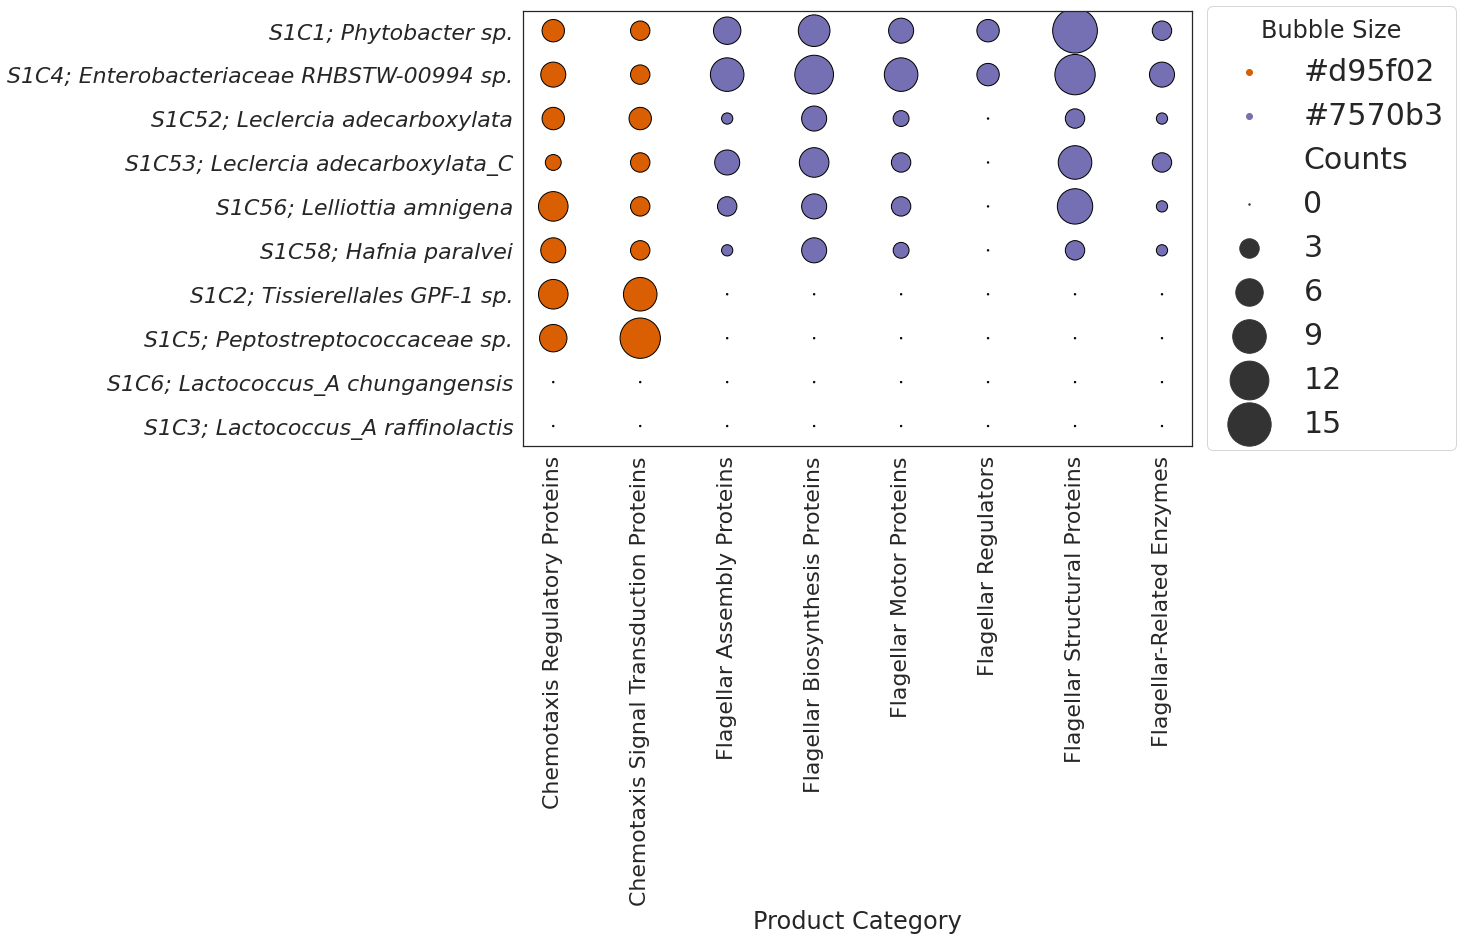

In [105]:

# Sample data (assuming 'motility_category_matrix' is your dataframe)
df = pd.DataFrame(motility_category_matrix.drop('Flagellar Function Modulators', axis=1))
df = df.loc[['S1C1; Phytobacter sp.',
             'S1C4; Enterobacteriaceae RHBSTW-00994 sp.',
             'S1C52; Leclercia adecarboxylata',
             'S1C53; Leclercia adecarboxylata_C',
             'S1C56; Lelliottia amnigena',
             'S1C58; Hafnia paralvei',
             'S1C2; Tissierellales GPF-1 sp.',
             'S1C5; Peptostreptococcaceae sp.',
             'S1C6; Lactococcus_A chungangensis',
             'S1C3; Lactococcus_A raffinolactis']]

df['genome_name'] = df.index

# Melt the DataFrame to get it in long-form for the bubble plot
df_melted = df.reset_index().melt(id_vars='genome_name', var_name='Product Category', value_name='Counts')

# Create a custom color palette
first_two_color = '#d95f02'  # Orange for the first two columns
other_color = '#7570b3'  # Blue-violet for the other columns

# Assign colors based on the column position
df_melted['Color'] = df_melted['Product Category'].apply(
    lambda x: first_two_color if x in df.columns[:2] else other_color
)

# Set the plot style
sns.set_style('white')
sns.set_context('notebook', font_scale=2)

# Create the bubble plot using seaborn
df_melted = df_melted[df_melted['Product Category'] != 'index']
plt.figure(figsize=(12, 8))
bubble_plot = sns.scatterplot(
    data=df_melted,
    x='Product Category',
    y='genome_name',
    size='Counts',
    linewidth=1,
    edgecolor='black',
    hue='Color',
    palette=[first_two_color, other_color],
    sizes=(2, 2000),
    legend="brief"
)

# Customize the plot
bubble_plot.set_xlabel('Product Category')
bubble_plot.set_ylabel('')
bubble_plot.tick_params(axis='x', rotation=90)

# Italicize the x-tick label
tick_labels = bubble_plot.get_yticklabels()
bubble_plot.set_yticklabels(df.index, fontstyle='italic')

# Customize the legend and move it outside the plot
handles, labels = bubble_plot.get_legend_handles_labels()
bubble_plot.legend(
    handles=handles[1:], labels=labels[1:], title="Bubble Size", loc="center left", 
    bbox_to_anchor=(1, 0.5), fontsize=30
)

# Show the plot
plt.savefig('motility_categories.png', bbox_inches='tight')
plt.show()


In [ ]:
len(set(S1C53_functions['subsystem_id']) - set(S1C52_functions['subsystem_id']))

26

In [ ]:
len(set(S1C53_functions['subsystem_id']).intersection(S1C52_functions['subsystem_id']))

224